### Importing Python Libraries

In [103]:
%matplotlib inline
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import random

### Loading the Mnist Dataset

In [120]:
def dataset_load(root="../mnist_project/data"):    
    train_data = torchvision.datasets.MNIST(root=root, train=True, transform=transforms.ToTensor(), download=False)
    test_tens = torchvision.datasets.MNIST(root=root, train=False, transform=transforms.ToTensor(), download=False)
    
    train_tens, val_tens = random_split(train_data, [50000, 10000], generator=torch.Generator().manual_seed(42))
    return train_tens, val_tens, test_tens

In [121]:
train_tensor, val_tensor, test_tensor = dataset_load()

### Lengths of our subsets

In [115]:
len(train_tensor), len(val_tensor), len(test_tensor)

(50000, 10000, 10000)

### Random sample shape - 28x28 picture

In [116]:
train_tensor[0][0].shape, train_tensor[0][1]

(torch.Size([1, 28, 28]), 6)

### Iterating and Visualizing the dataset

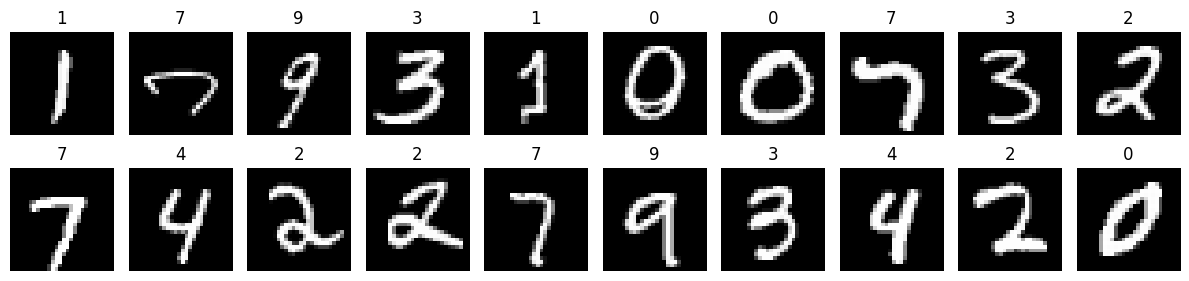

In [112]:
rand_idx = random.sample(range(0, len(train_tensor)), 20)

figure = plt.figure(figsize=(12, 3), tight_layout=True)

for i in range(len(rand_idx)):
    img, label = train_tensor[rand_idx[i]]
    figure.add_subplot(2, 10, i+1)
    plt.title(str(label))
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    
plt.show()